In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from finpak.data.fetchers.yahoo import download_multiple_tickers

In [17]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Use this device throughout your code
device = get_device()
print(f"Using device: {device}")

Using device: mps


In [40]:
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2000-04-01'
end_date = '2024-08-31'

# Download historical data for the tickers
data_df = download_multiple_tickers(tickers, start_date, end_date)
data_df = data_df.loc[:,'Adj Close'] # Extract from multi-index dataframe
data_df.tail(8)

[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,GOOGL,MSFT
Date,,,
2024-08-21 00:00:00+00:00,226.399994,165.630219,424.140015
2024-08-22 00:00:00+00:00,224.529999,163.582932,415.549988
2024-08-23 00:00:00+00:00,226.839996,165.400513,416.790009
2024-08-26 00:00:00+00:00,227.179993,165.939804,413.489990
2024-08-27 00:00:00+00:00,228.029999,164.461761,413.839996
2024-08-28 00:00:00+00:00,226.490005,162.634201,410.600006
2024-08-29 00:00:00+00:00,229.789993,161.565613,413.119995
2024-08-30 00:00:00+00:00,229.000000,163.163498,417.140015


In [41]:
data_df.head(2)

Ticker,AAPL,GOOGL,MSFT
Date,,,
2000-04-03 00:00:00+00:00,1.005170,NaN,28.016479
2000-04-04 00:00:00+00:00,0.959931,NaN,27.303549


In [4]:
data_df['AAPL'].values[-10:]

array([225.88999939, 226.50999451, 226.3999939 , 224.52999878,
       226.83999634, 227.17999268, 228.02999878, 226.49000549,
       229.78999329, 229.        ])

In [6]:
prices = data_df['AAPL'].values 
# Calculate percentage changes
pct_changes = np.diff(prices) / prices[:-1]

# Optionally adjust by volatility
adjust_by_volatility = False # True
if adjust_by_volatility:
    volatility = np.std(pct_changes)
    pct_changes = pct_changes / volatility

In [7]:
pct_changes[:10]

array([-0.04500606,  0.02405524, -0.03978892,  0.05242001, -0.05123333,
       -0.04449974, -0.0852957 ,  0.04176232, -0.01702321,  0.10726274])

In [8]:
len(pct_changes), len(prices)

(6141, 6142)

In [9]:
scaler = StandardScaler()
pct_changes = scaler.fit_transform(pct_changes.reshape(-1, 1)).flatten()
pct_changes[:10]

array([-1.91015878,  0.94547793, -1.69443369,  2.11834126, -2.16765216,
       -1.88922294, -3.57610755,  1.67765322, -0.75308758,  4.3860501 ])

In [10]:
"""
- **Create Sequences:**
  - Decide on a sequence length (e.g., 50).
  - Convert the percentage changes into input-output pairs where each input is a sequence of `sequence_length` steps, and the output is the next value.
"""

sequence_length = 10
X = []
y = []

for i in range(len(pct_changes) - sequence_length):
    X.append(pct_changes[i:i + sequence_length])
    y.append(pct_changes[i + sequence_length])

X = np.array(X)
y = np.array(y)

In [18]:
class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32).to(device)
        target = torch.tensor(self.targets[idx], dtype=torch.float32).to(device)
        return sequence, target


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # LSTM forward pass
        out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))  # x.unsqueeze(-1) to add input_size dimension

        # Take the output from the last time step
        out = self.fc(out[:, -1, :])
        return out.squeeze()

class SwishActivation(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.swish = SwishActivation()

    def forward(self, x, hidden=None):
        out, hidden = self.lstm(x, hidden)
        out = self.layer_norm(out)
        out = self.swish(out)
        return out, hidden

class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(EnhancedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.layers = nn.ModuleList([
            LSTMLayer(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
        self.fc = nn.Linear(hidden_size, 1)
        self.layer_norm_final = nn.LayerNorm(hidden_size)
        self.swish = SwishActivation()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        hidden = (h0, c0)

        residual = None
        for i, layer in enumerate(self.layers):
            if i == 0:
                out, hidden = layer(x.unsqueeze(-1), hidden)
            else:
                layer_input = out if residual is None else out + residual
                out, hidden = layer(layer_input, hidden)
            
            if i > 0:  # Apply residual connection for all layers except the first
                residual = out

        out = self.layer_norm_final(out)
        out = self.swish(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

In [15]:
# Create the full dataset
full_dataset = StockDataset(X, y)

# Define split ratios
train_ratio = 0.88
val_ratio = 0.12

# Calculate split indices
train_size = int(len(y) * train_ratio)
val_size = int(len(y) * val_ratio)

# Split the dataset sequentially
train_dataset = torch.utils.data.Subset(full_dataset, range(train_size))
val_dataset = torch.utils.data.Subset(full_dataset, range(train_size, train_size + val_size))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
#model = LSTMModel()
model = EnhancedLSTMModel(hidden_size=2048, num_layers=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00075)
best_val_loss = float('inf')

In [21]:
num_epochs = 112
patience = 18  # For early stopping
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            val_loss = criterion(outputs, targets)
            epoch_val_loss += val_loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # When saving the model, move it to CPU first
        torch.save(model.to('cpu').state_dict(), 'best_lstm_model.pth')
        model.to(device)  # Move it back to the device if you continue training
        print("New best model saved!")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    print('-' * 50)

Epoch [1/112]
Train Loss: 1.0857
Validation Loss: 0.5135
--------------------------------------------------
Epoch [2/112]
Train Loss: 1.0854
Validation Loss: 0.5131
--------------------------------------------------
Epoch [3/112]
Train Loss: 1.0851
Validation Loss: 0.5127
--------------------------------------------------
Epoch [4/112]
Train Loss: 1.0847
Validation Loss: 0.5123
--------------------------------------------------
Epoch [5/112]
Train Loss: 1.0836
Validation Loss: 0.5345
--------------------------------------------------
Epoch [6/112]
Train Loss: 1.0869
Validation Loss: 0.5156
--------------------------------------------------
Epoch [7/112]
Train Loss: 1.0864
Validation Loss: 0.5135
--------------------------------------------------
Epoch [8/112]
Train Loss: 1.0849
Validation Loss: 0.5121
--------------------------------------------------
Epoch [9/112]
Train Loss: 1.0839
Validation Loss: 0.5115
--------------------------------------------------
Epoch [10/112]
Train Loss: 1

In [35]:
"""
### **5. Model Inference and Graphing**

**Objective:** Use the trained model to make predictions, compare them with actual stock prices, and visualize the results.

- **Load the Trained Model:**
"""

model = EnhancedLSTMModel(hidden_size=2048, num_layers=3).to(device)
model.load_state_dict(torch.load('best_lstm_model.pth', weights_only=True))
model.eval()

# Select a starting point for prediction
start_idx = 0  # Change as needed
input_seq = pct_changes[start_idx:start_idx + sequence_length]
# input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch and feature dimensions

In [36]:
input_seq.shape

torch.Size([1, 10])

In [37]:
input_seq[0]

tensor([-1.9102,  0.9455, -1.6944,  2.1183, -2.1677, -1.8892, -3.5761,  1.6777,
        -0.7531,  4.3861], device='mps:0')

In [38]:
"""
- **Autoregressive Prediction:**
"""

prediction_length = 20  # Number of future steps to predict
predictions = []

with torch.no_grad():
    for _ in range(prediction_length):
        input_seq = input_seq.to(device)
        # Get the model prediction
        pred = model(input_seq)
        predictions.append(pred.item())

        # Update the input sequence by appending the prediction and removing the first element
        input_seq = torch.cat((input_seq[:, 1:], pred.unsqueeze(0).unsqueeze(-1)), dim=1).to(device)

In [44]:
"""
- **Denormalize Predictions (If Data Was Normalized):**
"""

# If you used StandardScaler
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actual_values = scaler.inverse_transform(pct_changes[start_idx + sequence_length:start_idx + sequence_length + prediction_length].reshape(-1, 1)).flatten()

# Reconstruct prices from percentage changes
last_known_price = prices[start_idx + sequence_length - 1]  # Adjust to use the last price before predictions start
predicted_prices = [last_known_price]
actual_prices = [last_known_price]

for pred_pct, actual_pct in zip(predictions, actual_values):
    next_predicted_price = predicted_prices[-1] * (1 + pred_pct)
    next_actual_price = actual_prices[-1] * (1 + actual_pct)
    predicted_prices.append(next_predicted_price)
    actual_prices.append(next_actual_price)

# Create a date range for the x-axis
prediction_dates = pd.date_range(start=data_df.index[start_idx + sequence_length - 1], periods=len(predicted_prices), freq='B')


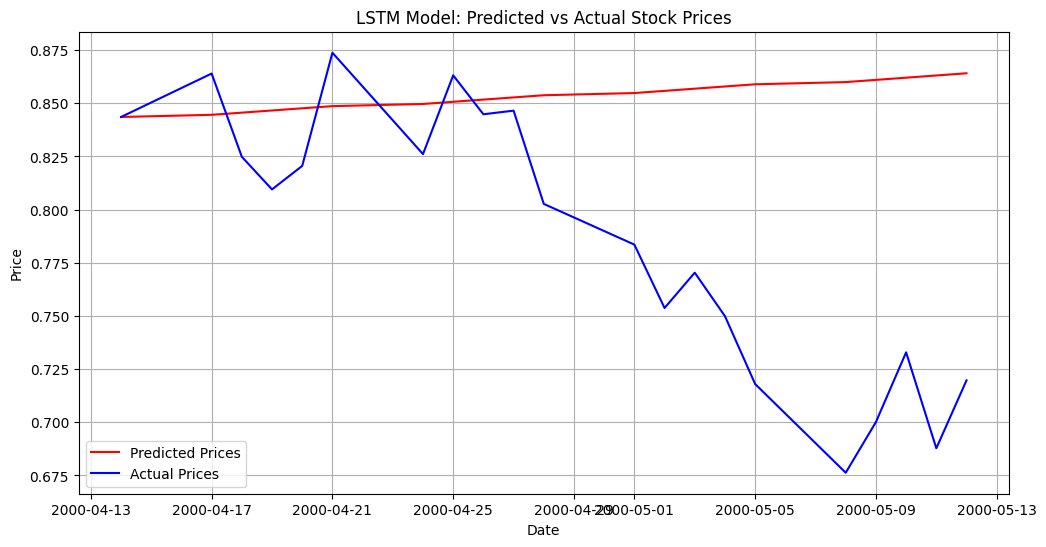

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(prediction_dates, predicted_prices, label='Predicted Prices', color='red')
plt.plot(prediction_dates, actual_prices, label='Actual Prices', color='blue')
plt.title('LSTM Model: Predicted vs Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# After loading the model and setting it to eval mode

# Define the validation set range
val_start = train_size
val_end = train_size + val_size

# Define prediction parameters
prediction_length = 20  # Number of future steps to predict
prediction_interval = 30  # Space between prediction start points

# Function to make predictions
def make_prediction(start_idx):
    input_seq = pct_changes[start_idx:start_idx + sequence_length]
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
    
    predictions = []
    with torch.no_grad():
        for _ in range(prediction_length):
            pred = model(input_seq)
            predictions.append(pred.item())
            input_seq = torch.cat((input_seq[:, 1:], pred.unsqueeze(0).unsqueeze(-1)), dim=1)
    
    return predictions

In [54]:
input_seq = pct_changes[start_idx:start_idx + sequence_length]
input_seq

array([-1.91015878,  0.94547793, -1.69443369,  2.11834126, -2.16765216,
       -1.88922294, -3.57610755,  1.67765322, -0.75308758,  4.3860501 ])

In [49]:
# Make predictions at intervals
prediction_starts = range(val_start, val_end - sequence_length - prediction_length, prediction_interval)
all_predictions = [make_prediction(start) for start in prediction_starts]

In [52]:
prediction_starts

range(5395, 6100, 30)

In [50]:
# Denormalize predictions and prepare for plotting
def prepare_prediction_data(predictions, start_idx):
    denorm_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    last_known_price = prices[start_idx + sequence_length - 1]
    predicted_prices = [last_known_price]
    for pred_pct in denorm_predictions:
        next_predicted_price = predicted_prices[-1] * (1 + pred_pct)
        predicted_prices.append(next_predicted_price)
    prediction_dates = pd.date_range(start=data_df.index[start_idx + sequence_length - 1], 
                                     periods=len(predicted_prices), freq='B')
    return prediction_dates, predicted_prices

# Prepare all prediction data
all_prediction_data = [prepare_prediction_data(pred, start) 
                       for pred, start in zip(all_predictions, prediction_starts)]

# Prepare actual price data for the entire validation period
val_dates = data_df.index[val_start:val_end]
val_prices = prices[val_start:val_end]

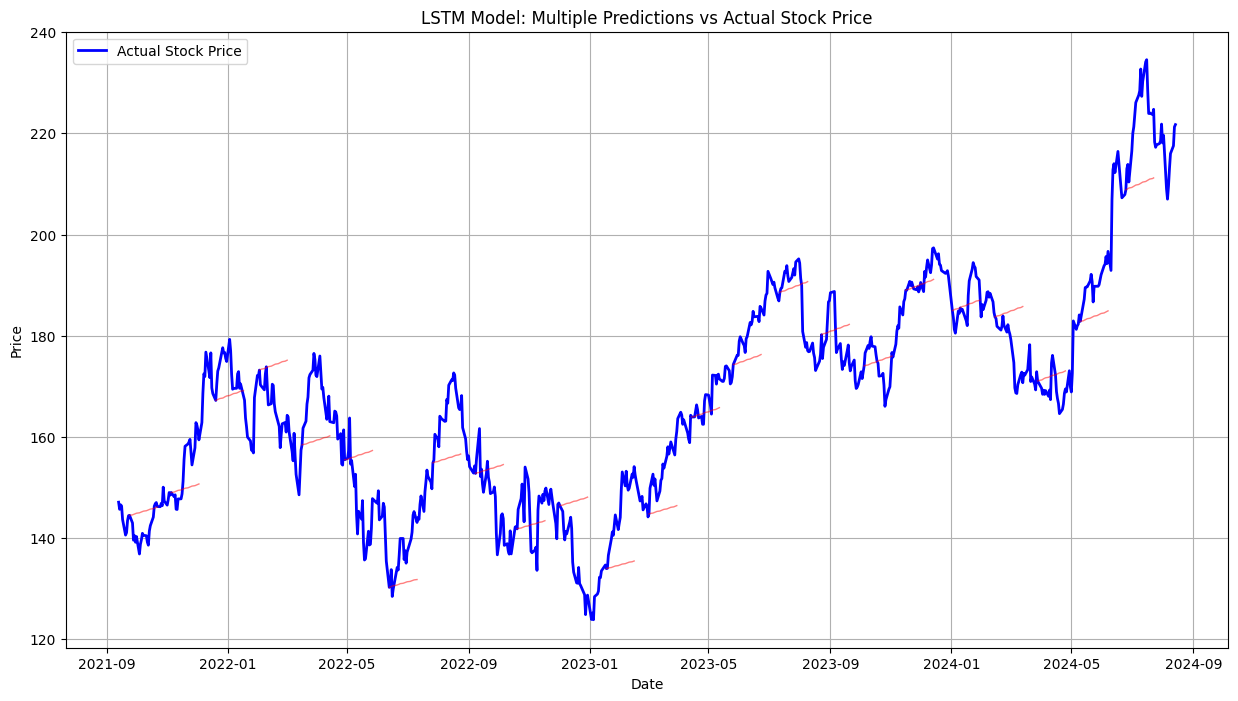

Mean Squared Error of predictions: 0.0028


In [51]:
# Plotting
plt.figure(figsize=(15, 8))

# Plot actual stock price
plt.plot(val_dates, val_prices, label='Actual Stock Price', color='blue', linewidth=2)

# Plot prediction lines
for dates, predicted_prices in all_prediction_data:
    plt.plot(dates, predicted_prices, color='red', alpha=0.5, linewidth=1)

plt.title('LSTM Model: Multiple Predictions vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, you can add a legend for predictions
plt.plot([], [], color='red', alpha=0.5, label='Predictions')
plt.legend()

# Save the plot
plt.savefig('lstm_predictions.png')
plt.close()

# Print some statistics
mse = np.mean([((pred[-1] - actual) / actual) ** 2 
               for (_, pred), actual in zip(all_prediction_data, val_prices[prediction_length::prediction_interval])])
print(f"Mean Squared Error of predictions: {mse:.4f}")

In [ ]:
!jupyter nbconvert --to python --no-prompt --ClearOutputPreprocessor.enabled=True lstm_nb1.ipynb